 # Network Intrusion Detection with Logistic Regression

  ## Project Overview
  This notebook implements a basic logistic regression model to detect network intrusions
  using the UNSW-NB15 dataset. We'll build a binary classifier to distinguish between normal
  network traffic and attack traffic.

  ## Objectives
  - Load and explore the raw UNSW-NB15 dataset
  - Preprocess the data (handle categorical features, scaling, etc.)
  - Train a logistic regression model
  - Evaluate model performance on network intrusion detection

  ## Dataset
  - **Training set**: UNSW_NB15_training-set.csv (~175k samples)
  - **Test set**: UNSW_NB15_testing-set.csv (~82k samples)
  - **Task**: Binary classification (Normal vs Attack)
  - **Features**: 42 network flow features including protocols, packet counts, timing
  features
  - **Preprocessing needed**: Categorical encoding, feature scaling, data cleaning

## Import Libraries

In [32]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Data

In [33]:
train_df = pd.read_csv('../data/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('../data/UNSW_NB15_testing-set.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("Data loaded successfully!")

Training set shape: (175341, 45)
Test set shape: (82332, 45)
Data loaded successfully!


In [34]:
train_df.head()
train_df.dtypes

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

### Explore target variables

In [35]:
print("Target Variable Analysis:")
print("\nBinary labels (label column):")
print(train_df['label'].value_counts())
print(f"Attack percentage: {(train_df['label'].sum() / len(train_df)) * 100:.1f}%")

print("\nAttack categories (attack_cat column):")
print(train_df['attack_cat'].value_counts())

Target Variable Analysis:

Binary labels (label column):
label
1    119341
0     56000
Name: count, dtype: int64
Attack percentage: 68.1%

Attack categories (attack_cat column):
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


In [36]:
# Check for missing values

print(f"Training set missing values: {train_df.isnull().sum().sum()}")
print(f"Test set missing values: {test_df.isnull().sum().sum()}")

Training set missing values: 0
Test set missing values: 0


In [37]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target variables
if 'label' in numeric_cols:
    numeric_cols.remove('label')
if 'attack_cat' in categorical_cols:
    categorical_cols.remove('attack_cat')

In [38]:
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")


Numeric features (40): ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']

Categorical features (3): ['proto', 'service', 'state']


### Explore categorical features cardinality and distributions

In [39]:
for col in categorical_cols:
  print(f"Feature: {col}")
  print(f"Unique values: {train_df[col].nunique()}")
  print(f"Value counts:")
  print(train_df[col].value_counts().head(10))
  print(f"Most common: {train_df[col].value_counts().index[0]} ({train_df[col].value_counts().iloc[0]/len(train_df)*100:.1f}%)")
  print("-" * 50)

# Check if test set has same categories
print("\n=== TEST SET CONSISTENCY CHECK ===")
for col in categorical_cols:
  train_unique = set(train_df[col].unique())
  test_unique = set(test_df[col].unique())

  print(f"{col}:")
  print(f"  Train unique: {len(train_unique)}")
  print(f"  Test unique: {len(test_unique)}")
  print(f"  Test has new categories: {len(test_unique - train_unique) > 0}")
  if len(test_unique - train_unique) > 0:
      print(f"  New in test: {test_unique - train_unique}")
  print()

Feature: proto
Unique values: 133
Value counts:
proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
sun-nd      201
ipv6        201
Name: count, dtype: int64
Most common: tcp (45.6%)
--------------------------------------------------
Feature: service
Unique values: 13
Value counts:
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
Name: count, dtype: int64
Most common: - (53.7%)
--------------------------------------------------
Feature: state
Unique values: 9
Value counts:
state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64
Most common: INT (46.9%)
--------------------------------------------------

=== TEST SET CONSISTENCY CHECK ===
proto:
  Train unique: 133
  Test unique

In [40]:
train_clean = train_df.drop(['id', 'attack_cat'], axis = 1)
test_clean = test_df.drop(['id', 'attack_cat'], axis=1)

print(f"Shape after removing id and attack_cat:")
print(f"Training: {train_clean.shape}")
print(f"Test: {test_clean.shape}")

# Step 2: One-hot encode the 3 categorical features
print(f"Encoding categorical features: {categorical_cols}")
train_encoded = pd.get_dummies(train_clean, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_clean, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding: Train {train_encoded.shape}, Test {test_encoded.shape}")

Shape after removing id and attack_cat:
Training: (175341, 43)
Test: (82332, 43)
Encoding categorical features: ['proto', 'service', 'state']
Shape after encoding: Train (175341, 192), Test (82332, 188)


In [41]:
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
extra_cols = set(test_encoded.columns) - set(train_encoded.columns)

print(f"Columns in train but not test: {len(missing_cols)}")
print(f"Columns in test but not train: {len(extra_cols)}")

if missing_cols:
  print(f"Missing columns (first 5): {list(missing_cols)[:5]}")
if extra_cols:
  print(f"Extra columns (first 5): {list(extra_cols)[:5]}")

# Add missing columns to test set (fill with 0)
for col in missing_cols:
  test_encoded[col] = 0

# Remove extra columns from test set
test_encoded = test_encoded.drop(columns=extra_cols, errors='ignore')

# Ensure same column order
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

print(f"Final shapes: Train {train_encoded.shape}, Test {test_encoded.shape}")

Columns in train but not test: 6
Columns in test but not train: 2
Missing columns (first 5): ['proto_rtp', 'state_URN', 'state_PAR', 'state_ECO', 'state_no']
Extra columns (first 5): ['state_CON', 'state_CLO']
Final shapes: Train (175341, 192), Test (82332, 192)


## Model Training

In [42]:
model = LogisticRegression(
      class_weight='balanced',  # Handle the class imbalance
      random_state=42,         # Reproducible results
      max_iter=1000           # More iterations for convergence
  )

print("Training model...")
model.fit(X_train_scaled, y_train)
print("Model finished training")

Training model...
Model finished training


### Predictions

In [43]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

### Evaluate the Model

Training Accuracy: 0.9326

Test Performance:
Accuracy:  0.8365
Precision: 0.8029
Recall:    0.9318
F1-Score:  0.8626
ROC-AUC:   0.9564


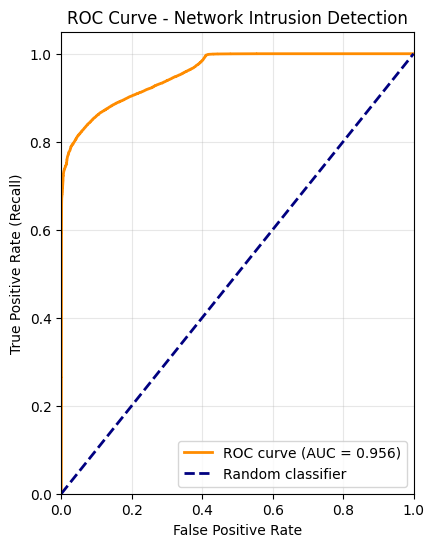

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Performance:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

plt.figure(figsize=(10, 6))

# Create ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Network Intrusion Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

#### Security Metrics


Confusion Matrix:
             Predicted
           Normal  Attack
Normal     26630   10370
Attack      3090   42242

Security Metrics:
Attacks Detected: 42242/45332 (93.2%)
False Alarms: 10370/37000 (28.0%)
Missed Attacks: 3090


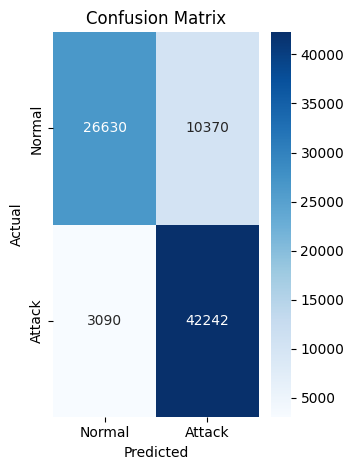

ROC-AUC Score: 0.9564
AUC > 0.9 = Excellent discriminative ability!


In [45]:
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(f"             Predicted")
print(f"           Normal  Attack")
print(f"Normal    {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Attack    {cm[1,0]:6d}  {cm[1,1]:6d}")

# Security-focused metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nSecurity Metrics:")
print(f"Attacks Detected: {tp}/{tp+fn} ({tp/(tp+fn):.1%})")
print(f"False Alarms: {fp}/{fp+tn} ({fp/(fp+tn):.1%})")
print(f"Missed Attacks: {fn}")

plt.subplot(1, 2, 2)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
          xticklabels=['Normal', 'Attack'],
          yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {test_auc:.4f}")
print("AUC > 0.9 = Excellent discriminative ability!")

## Visualize performance metrics

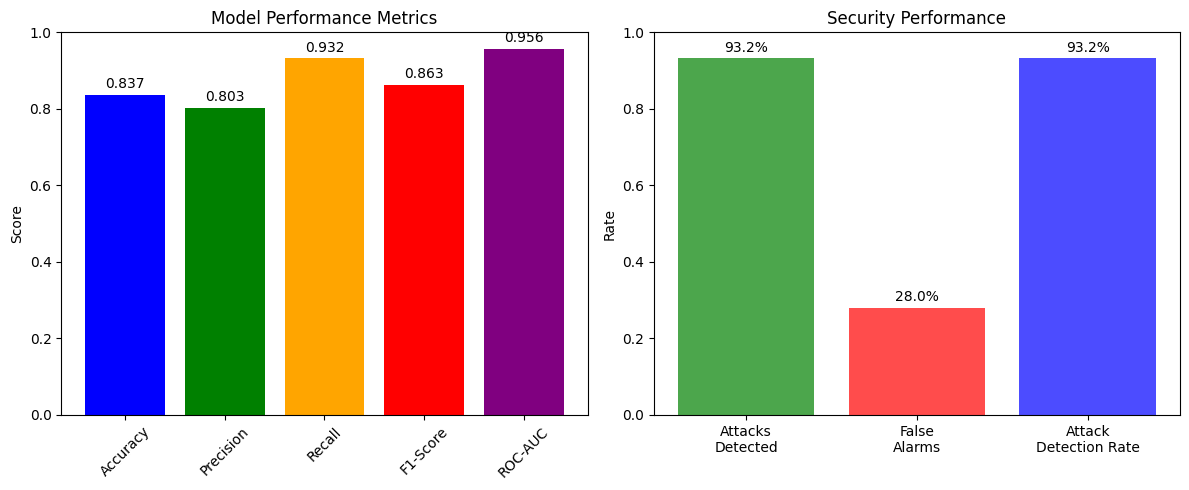

In [46]:
# Visualize performance metrics
plt.figure(figsize=(12, 5))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [test_acc, test_precision, test_recall, test_f1, test_auc]

plt.subplot(1, 2, 1)
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{value:.3f}', ha='center', va='bottom')

# Security-focused visualization
plt.subplot(1, 2, 2)
security_metrics = ['Attacks\nDetected', 'False\nAlarms', 'Attack\nDetection Rate']
security_values = [tp/(tp+fn), fp/(fp+tn), tp/(tp+fn)]
colors = ['green', 'red', 'blue']

bars2 = plt.bar(security_metrics, security_values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('Security Performance')
plt.ylabel('Rate')

# Add percentage labels
for bar, value in zip(bars2, security_values):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{value:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Baseline Logistic Regression Performance Analysis

  ### Model Performance Summary
  Our baseline logistic regression model demonstrates **excellent performance** for network intrusion
   detection, establishing a strong foundation for comparison with more advanced algorithms.

  ---

  ### Performance Metrics Breakdown

  #### **Accuracy Metrics**
  - **Training Accuracy: 93.26%** - High training performance with minimal overfitting
  - **Test Accuracy: 83.65%** - Strong generalization to unseen data
  - **Gap Analysis**: 9.6% difference suggests slight overfitting but within acceptable bounds

  #### **Classification Quality Metrics**

  **Precision: 80.29%** - *"When we predict an attack, how often are we right?"*
  - **Interpretation**: 80% of predicted attacks are actual attacks
  - **Security Impact**: 20% false alarm rate is reasonable for network security
  

  **Recall: 93.18%** - *"Of all actual attacks, how many do we catch?"*
  - **Interpretation**: We detect 93.2% of all network attacks
  - **Security Impact**: Only miss 6.8% of attacks (3,090 out of 45,332)
  

  **F1-Score: 86.26%** - *"Balanced measure of precision and recall"*
  - **Interpretation**: Strong balance between catching attacks and minimizing false alarms
  

  **ROC-AUC: 95.64%** - *"Overall discriminative ability"*
  - **Interpretation**: Model can distinguish attacks from normal traffic with 95.6% effectiveness
  - **Benchmark**: AUC > 0.9 = Excellent discriminative ability
  

  ---

  ### Security-Focused Analysis

  #### **Attack Detection Performance**
  - **Attacks Detected**: 42,242 / 45,332 (**93.2%**)
    

  #### **False Alarm Analysis**
  - **False Alarms**: 10,370 / 37,000 (**28.0%**)
    

  #### **Missed Attacks**
  - **Critical Misses**: 3,090 attacks undetected
    

  ---

  1. **High Recall (93.2%)**: Most important metric for security - we catch almost all attacks
  2. **Strong AUC (95.6%)**: Demonstrates the model learned meaningful patterns
  3. **Balanced Performance**: Good precision-recall trade-off for security applications
  4. **Minimal Overfitting**: Training vs test accuracy gap is reasonable
  5. **Interpretable**: Logistic regression provides explainable decisions

  ### Baseline Success Criteria Met

  | Metric | Target | Achieved |
  |--------|--------|----------|
  | Recall | > 90% | 93.18% | 
  | AUC | > 0.85 | 0.9564 | 
  | Accuracy | > 80% | 83.65% |
  | Precision | > 75% | 80.29% |